In [1]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/utils/ ./

Cloning into 'dsaa5002'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
%%time

from utils.utils import create_dataset, Trainer

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cpu].
CPU times: user 1.06 s, sys: 1.09 s, total: 2.15 s
Wall time: 27.7 s


In [3]:
%%time

SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()

CPU times: user 11.9 ms, sys: 6.52 ms, total: 18.5 ms
Wall time: 128 ms


In [4]:
class EE_Loss:
    def __init__(self, model, reg_biase=0.005, reg_lambda=0.005):
        self.reg_biase = reg_biase
        self.reg_lambda = reg_lambda
        self.model = model

    def __call__(self, pred, target):
        loss = (1-self.reg_biase - self.reg_lambda) * nn.MSELoss()(pred, target)
        loss += self.reg_biase * self.model.loss[0]
        loss += self.reg_lambda * self.model.loss[1]
        return loss


class EuclideanEmbedding(nn.Module):

    def __init__(self, field_dims, embed_dim=4):
        super(EuclideanEmbedding, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]
        self.Bu = nn.Parameter(torch.randn(n_users), requires_grad=True)
        self.Bm = nn.Parameter(torch.randn(n_movies), requires_grad=True)
        self.u = nn.Embedding(n_users, embed_dim)
        self.m = nn.Embedding(n_movies, embed_dim)
        
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)
        self.loss = [0,0]

        
    def forward(self, x, global_mean=0):
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        Bu, Bm = self.Bu[users], self.Bm[movies]
        difference = u-m
        output = global_mean + Bu + Bm - torch.linalg.norm(torch.mul(difference, difference))
        
        self.loss[0] = torch.norm(Bu) + torch.norm(Bm)
        self.loss[1] = torch.norm(u) + torch.norm(m)
        return output

In [5]:
ee = EuclideanEmbedding([10, 37])

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([832, 1])) that is different to the input size (torch.Size([832])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they

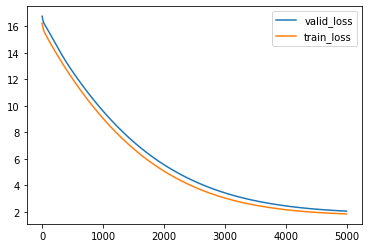

train_loss: 2.83508 | train_metric: -2.83508
valid_loss: 2.04510 | valid_metric: -2.04510
test_loss:  2.12218 | test_metric:  -2.12218
CPU times: user 1h 10s, sys: 26.5 s, total: 1h 36s
Wall time: 1h 23s


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([8000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [6]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024
EPOCH = 5000
TRIAL = 1000

ee = EuclideanEmbedding(field_dims, EMBEDDING_DIM).to(device)

optimizer = optim.Adam(ee.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = EE_Loss(model=ee)

trainer = Trainer(ee, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
